In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from collections import Counter
import scipy.stats as ss
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import keras
from keras.models import Sequential
from sklearn import preprocessing
from sklearn import tree
from sklearn import model_selection

### Loading Datasets 

In [2]:
test = pd.read_csv("Test.csv")
train = pd.read_csv("Train.csv")
test.Product_Category = None
#train = 5719

#### Checking for Nulls

In [3]:
train.isnull().values.any()

False

In [4]:
test.isnull().values.any()

False

> Good, no missing data points

### Creating a List of categorical column

In [5]:
cat_cols = train.select_dtypes(exclude=['int', 'float']).columns

In [6]:
# Counting the unique data in each of the categorical column
for feature in cat_cols:
    uniq = np.unique(train[feature])
    print('{}: No. of distinct values -  {}'.format(feature,len(uniq)))

Inv_Id: No. of distinct values -  5719
Vendor_Code: No. of distinct values -  1313
GL_Code: No. of distinct values -  9
Item_Description: No. of distinct values -  5118
Product_Category: No. of distinct values -  38


> Concatinating train and test data and performing few of the Data Wrangling and Data Cleaning

In [7]:
df = pd.concat([train, test],axis=0)

C:\Users\Jyoti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
df.head()

GL_Code    Inv_Amt  Inv_Id  \
0  GL-6050100   6.973473       1   
1  GL-6050100  25.053841       2   
2  GL-6050100  53.573737       3   
3  GL-6050100  67.388827       4   
4  GL-6050100  74.262047       5   

                                    Item_Description Product_Category  \
0  AETNA VARIABLE FUND - Apr-2002 - Store Managem...        CLASS-784   
1  AETNA VARIABLE FUND - Nov-2000 - Store Managem...        CLASS-784   
2  FAIRCHILD CORP - Nov-2001 - Store Management R...        CLASS-784   
3  CALIFORNIA REAL ESTATE INVESTMENT TRUST - Aug-...        CLASS-784   
4  CALIFORNIA REAL ESTATE INVESTMENT TRUST - Mar-...        CLASS-784   

  Vendor_Code  
0   VENDOR-61  
1   VENDOR-61  
2  VENDOR-449  
3  VENDOR-682  
4  VENDOR-682

In [9]:
df.columns

Index(['GL_Code', 'Inv_Amt', 'Inv_Id', 'Item_Description', 'Product_Category',
       'Vendor_Code'],
      dtype='object')

### Data Wrangling

> Created 4 fields from Item Description column of the data set
> 1. Company Name
> 2. Month
> 3. Year
> 4. Group

> After separating out this column we will analyse the affect of these column into Product category latter in this notebook and predict the output using these fields.

> Note: there were few item descriptions data which has extra hyphens in between the company name or group so we took care of that

In [10]:
# checking the pattern
df['Item_Description'].head()

0    AETNA VARIABLE FUND - Apr-2002 - Store Managem...
1    AETNA VARIABLE FUND - Nov-2000 - Store Managem...
2    FAIRCHILD CORP - Nov-2001 - Store Management R...
3    CALIFORNIA REAL ESTATE INVESTMENT TRUST - Aug-...
4    CALIFORNIA REAL ESTATE INVESTMENT TRUST - Mar-...
Name: Item_Description, dtype: object

In [11]:
# Creating new fields  from item_Description
Comp_Name = []
Month = []
Year = []
Group = []
mon = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]

for idx,i in enumerate(df['Item_Description']):
    s = i.split("-")
    l = len(s)
    splitidx=0
    for jidx,j in enumerate(s):
        j = j.upper().strip()
        if j in mon:
            splitidx = jidx
            break
    cmp=""
    grp=""
    for i in range(0,splitidx):
        cmp=cmp+s[i]
    Comp_Name.append(cmp)
    Month.append(s[splitidx])
    Year.append(s[splitidx+1])
    for i in range(splitidx+2,l):
        grp=grp+s[i]
    Group.append(grp)
df['Comp_Name']=Comp_Name
df['Month']=Month
df['Year']=Year
df['Group']= Group
        

    

In [12]:
# checking extra hypens rows data,if split happened correctly or not for those records 
#df[df['Comp_Name'].str.contains("ASSOCIATED")]
df[df['Comp_Name'].str.contains("AMERACE")]



GL_Code    Inv_Amt  Inv_Id  \
552  GL-6101400  74.686875     764   

                                      Item_Description Product_Category  \
552  AMERACE CORP 1967 QUAL STK OPT PL & 1972 QUAL-...        CLASS-913   

    Vendor_Code                                          Comp_Name Month  \
552  VENDOR-159  AMERACE CORP 1967 QUAL STK OPT PL & 1972 QUALN...   Jun   

      Year                                              Group  
552  2002    Store Construction Fixtures Store Fixtures St...

>Removed VENDOR Literal from the Vendor_Code column and Creating a new column as VC_Filtered as this is not adding any value to analysis

In [13]:
#Removing Class from Vendor Code
li = []
for i in df["Vendor_Code"]:
    temp1,temp2=i.split("-")
    li.append(temp2)
df["VC_Filtered"] = li

> As we extracted required info from Item_description column, this column is not required likewise for the case of Vendor Code. 

> Inv is just a unique number assigned to an order so removing this columns as well

In [14]:
df.drop(['Vendor_Code','Item_Description','Inv_Id'],axis=1,inplace = True)

In [15]:
cat_cols = df.select_dtypes(exclude=['int', 'float']).columns
for feature in cat_cols:
    #print(feature)
    uniq = df[feature].nunique()
    print('{}: No. of distinct values -  {}'.format(feature,(uniq)))

GL_Code: No. of distinct values -  9
Product_Category: No. of distinct values -  38
Comp_Name: No. of distinct values -  1594
Month: No. of distinct values -  12
Year: No. of distinct values -  20
Group: No. of distinct values -  38
VC_Filtered: No. of distinct values -  1560


> Now we dive deeper to the columns relation. More formealy, we want to know if there's a certain feature that maximizes the information about the class. For this, we will use Theil's U, also known as the Uncertainty Coefficient. Formaly marked as U(x|y), this coefficient provides a value in the range of [0,1], where 0 means that feature y provides no information about feature x, and 1 means that feature y provides full information abpout features x's value. 

In [16]:

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

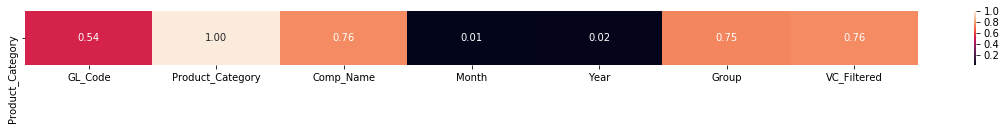

In [17]:
theilu = pd.DataFrame(index=['Product_Category'],columns=cat_cols)
columns = cat_cols
for j in range(0,len(columns)):
    u = theil_u(df['Product_Category'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

> As can be seen Comp_name,Group , VC_Filtered can be used for prediction

### Checking relationship between Product category and group field extracted from Item_decription

In [18]:
train_modified = df[:len(train)]
test_modified = df[:len(test)]

In [19]:
li = []
for i in train_modified["Product_Category"]:
    #print(i)
    temp1,temp2=i.split("-")
    li.append(temp2)
train_modified["Product_Category_filtered"] = li
li1 = train_modified['Product_Category_filtered'].unique()
intli = []
for i in li1:
    intli.append(int(i))
li=[]
intli = sorted(intli)
for i in intli:
    li.append(str(i))
print(li)

['49', '50', '51', '74', '75', '95', '110', '123', '177', '230', '278', '322', '323', '368', '453', '489', '522', '559', '571', '606', '629', '651', '668', '671', '720', '758', '764', '765', '783', '784', '804', '816', '839', '913', '942', '947', '953', '1042']


C:\Users\Jyoti\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
i = '49'
grtempdf  = train_modified[train_modified["Product_Category_filtered"]== i]
grtempdf.head()

GL_Code    Inv_Amt Product_Category                 Comp_Name Month  \
452  GL-2182000  89.552884         CLASS-49          CUSTOMEDIX CORP    Mar   
546  GL-2182000   3.362255         CLASS-49   CENTRAL MAINE POWER CO    Jun   
547  GL-2182000  15.520426         CLASS-49   CENTRAL MAINE POWER CO    Sep   
548  GL-2182000  30.563550         CLASS-49     CENTRAL OHIO COAL CO    Dec   
549  GL-2182000  68.846002         CLASS-49  CENTRAL SECURITIES CORP    Apr   

      Year                                              Group VC_Filtered  \
452  2004    Corporate Services Consulting Finance Consult...        1112   
546  2015    Corporate Services Consulting Finance Consult...         778   
547  2015    Corporate Services Consulting Finance Consult...         778   
548  2005    Corporate Services Consulting Finance Consult...         779   
549  2010    Corporate Services Consulting Finance Consult...         781   

    Product_Category_filtered  
452                        49  
546                        49  
547                        49  
548                        49  
549                        49

> Plotting group for each product category to check if a product category belongs to one or more group

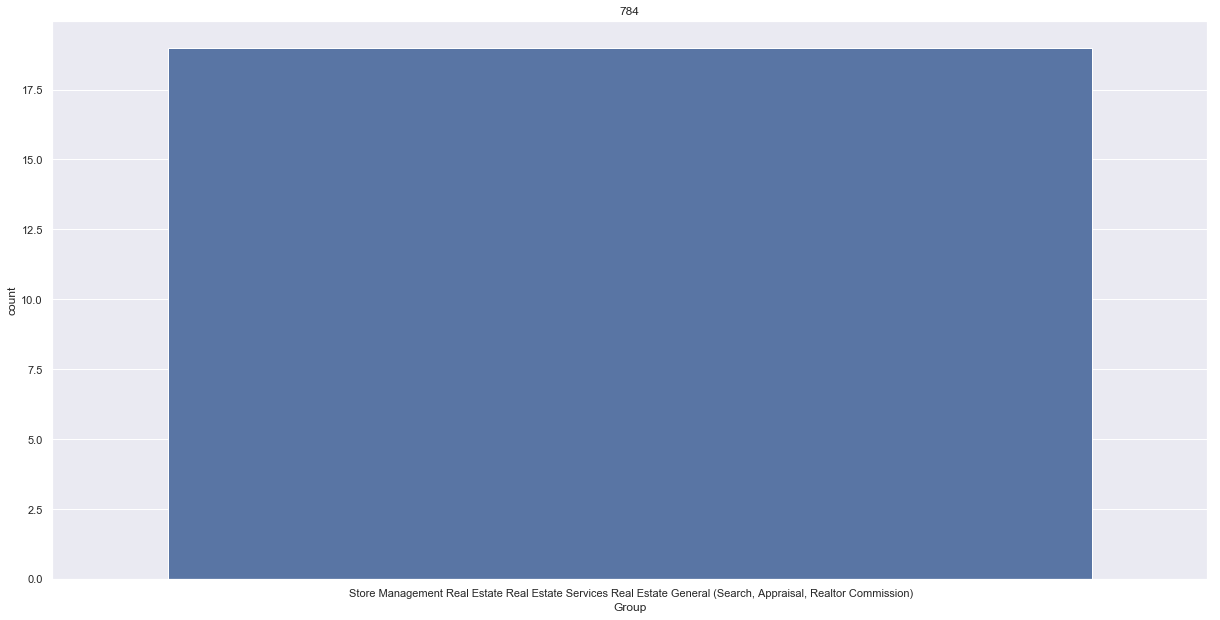

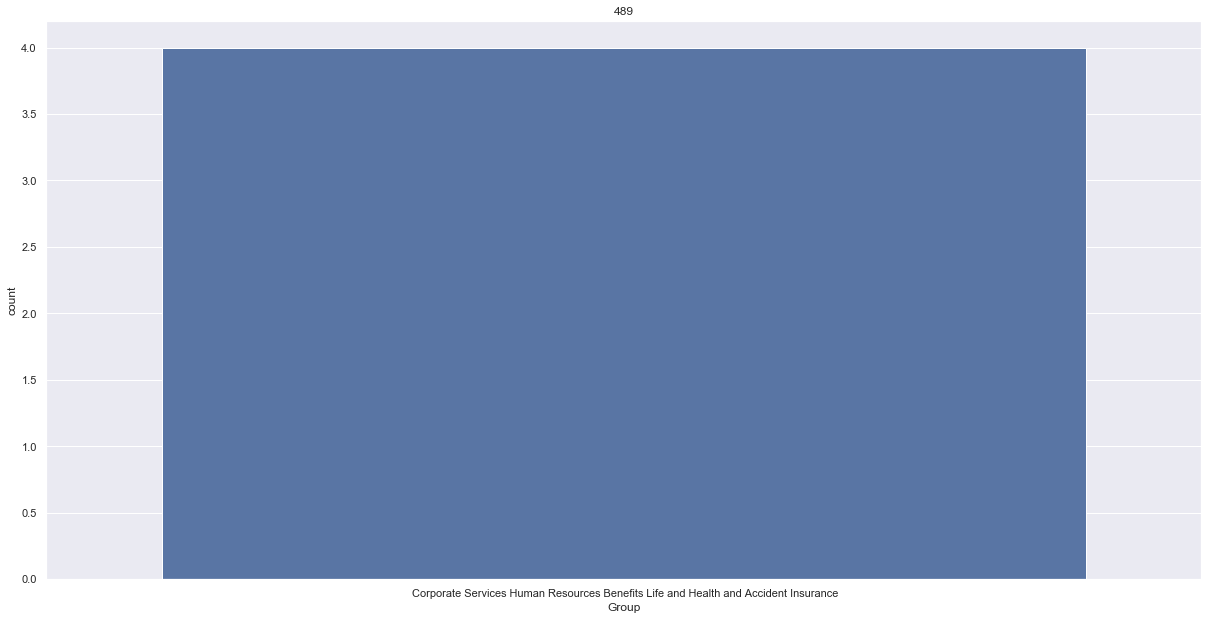

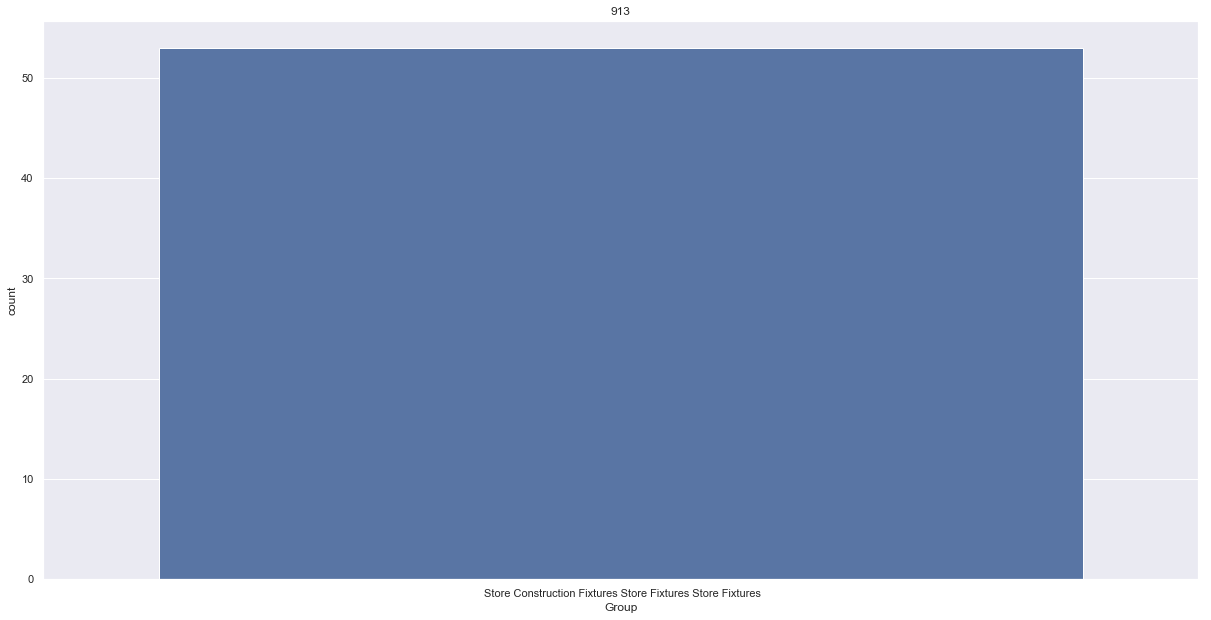

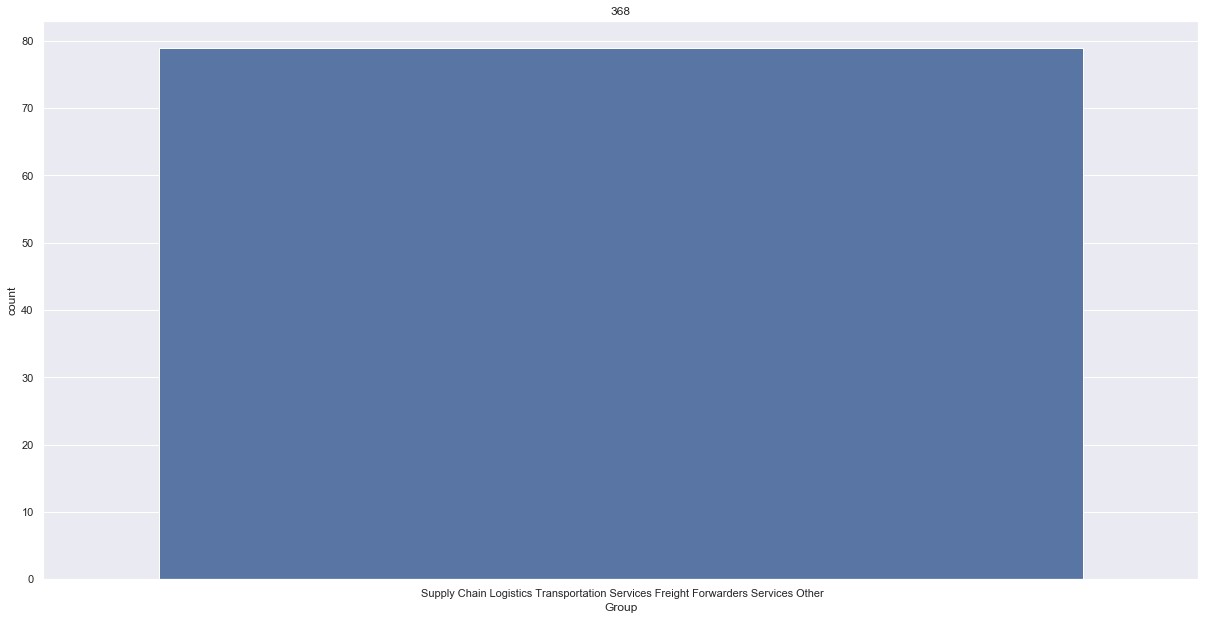

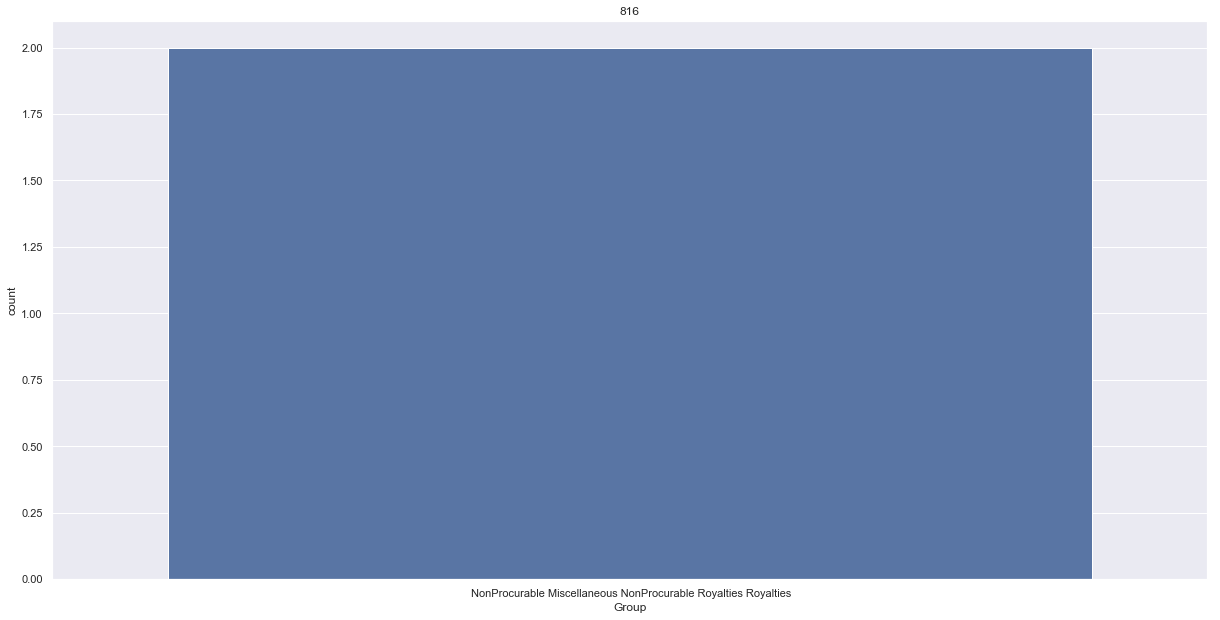

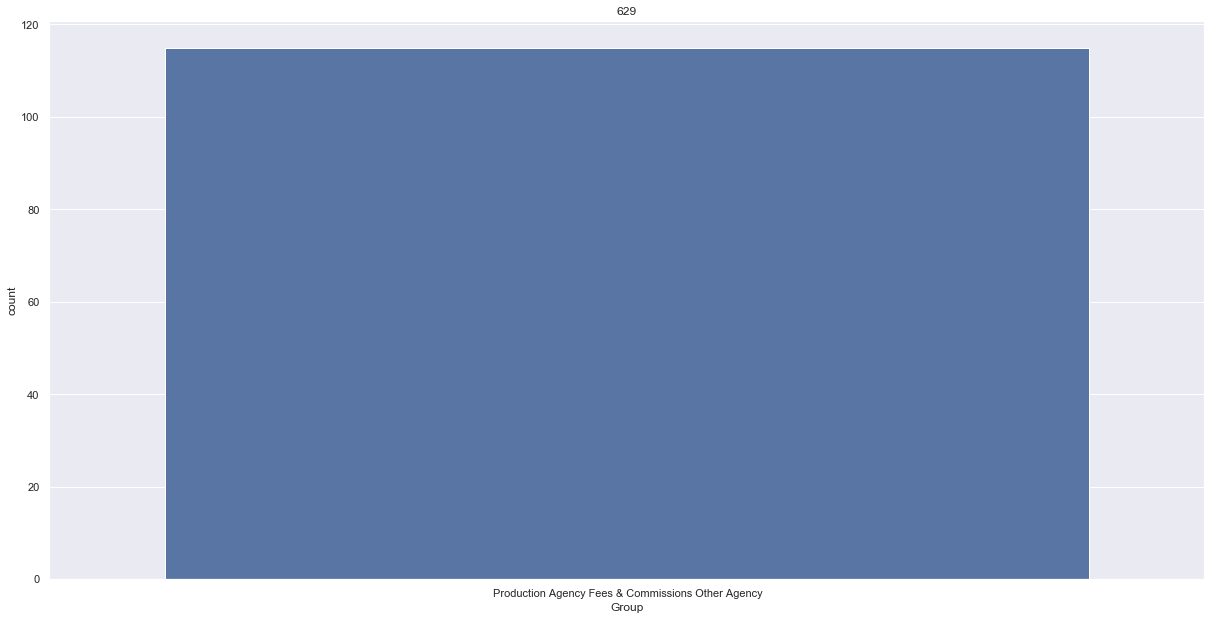

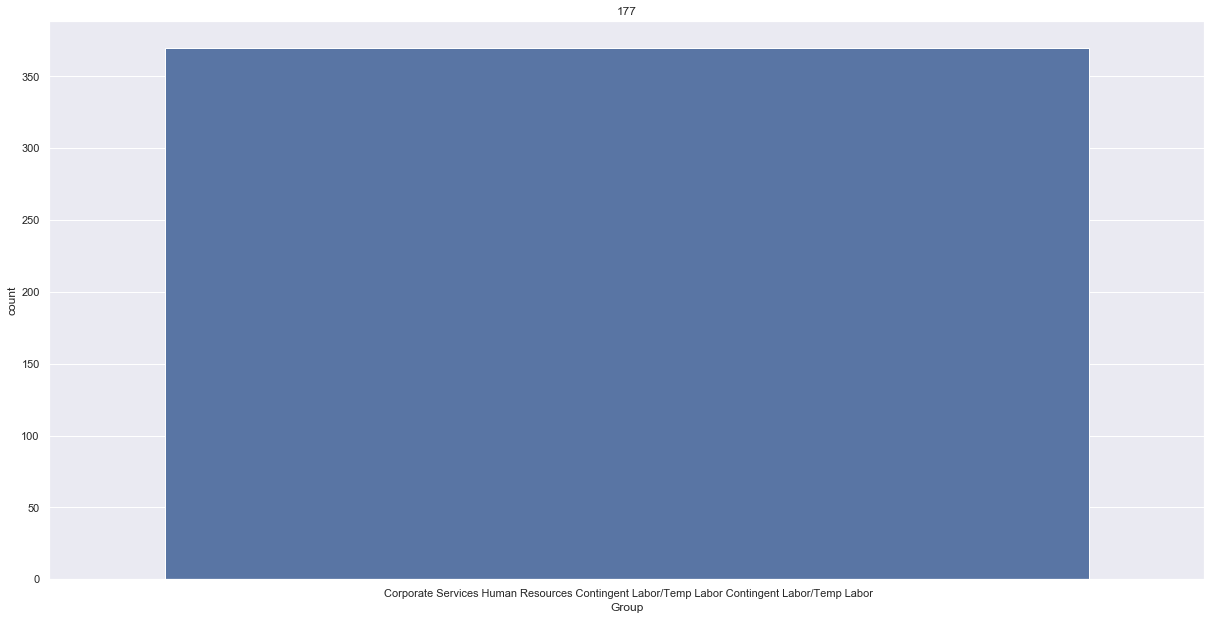

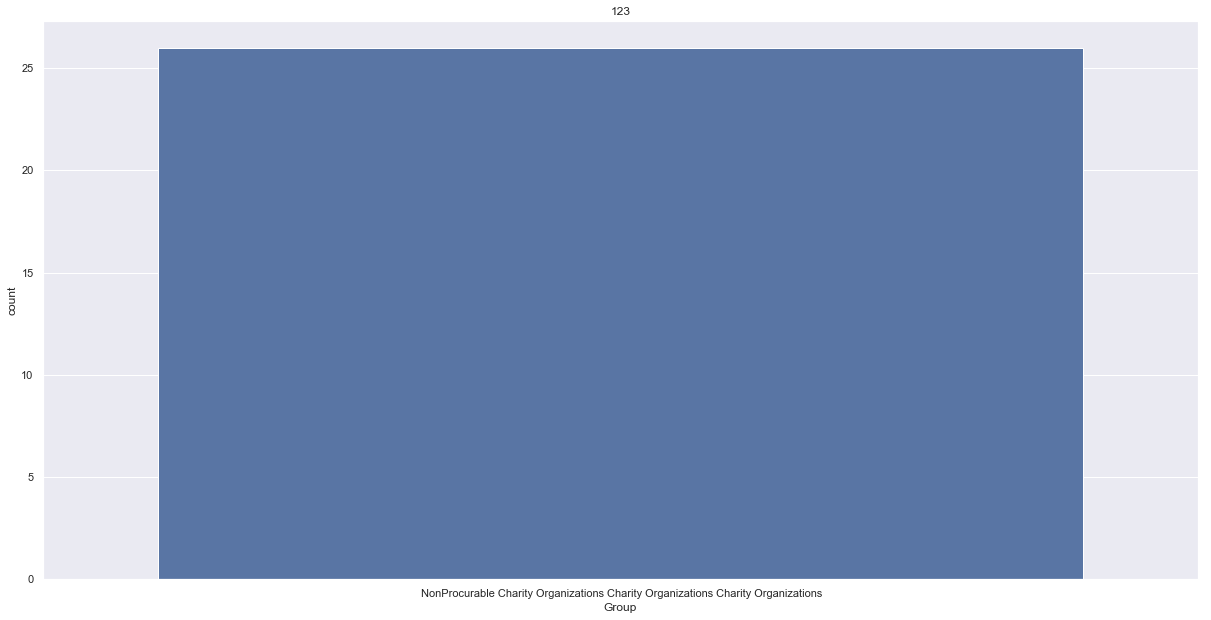

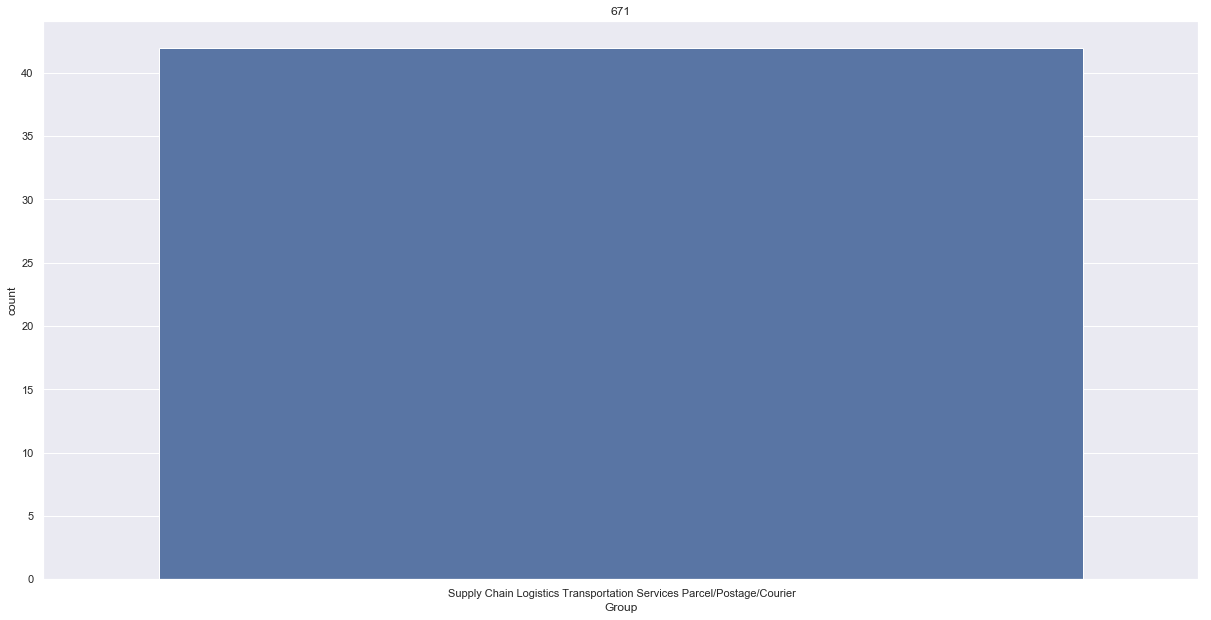

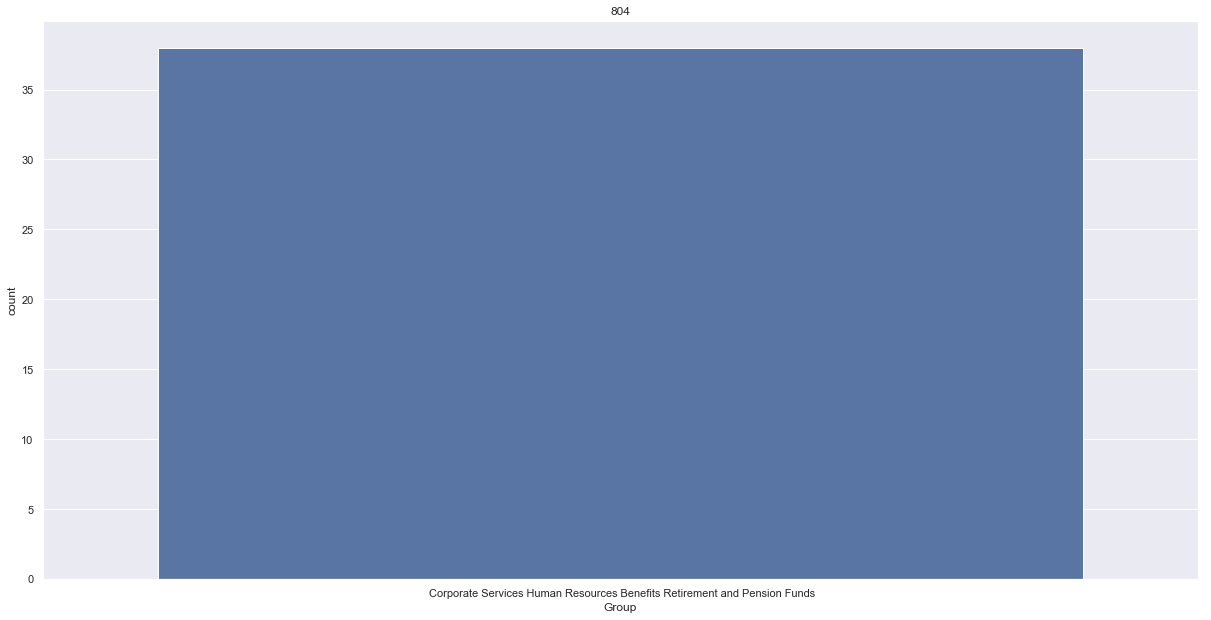

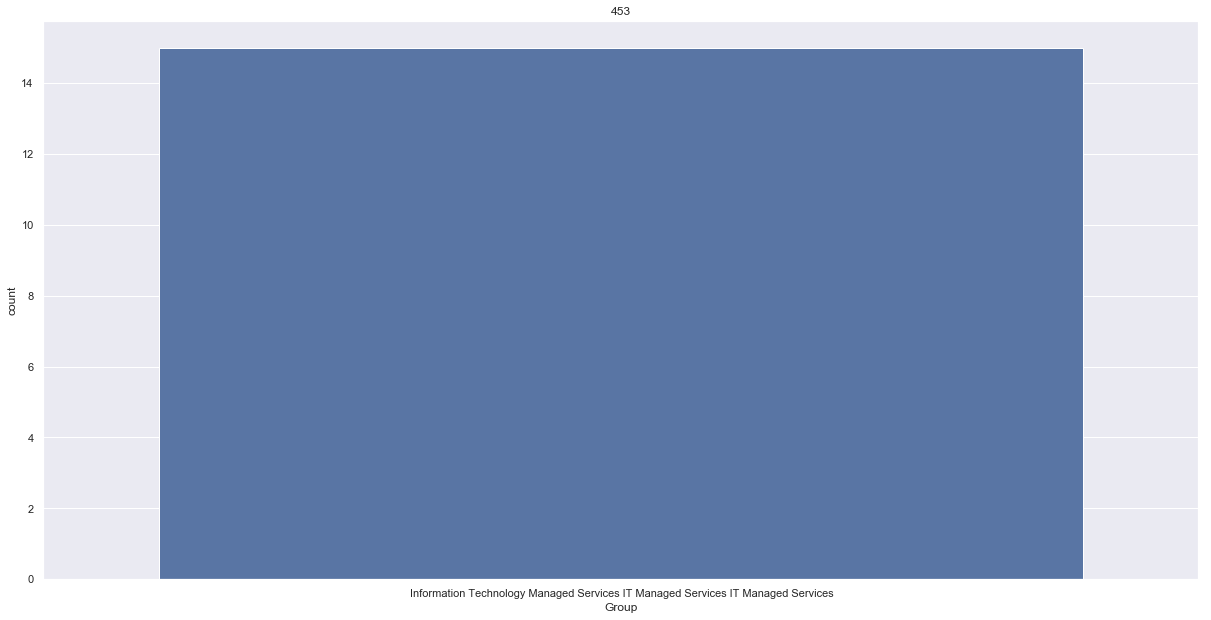

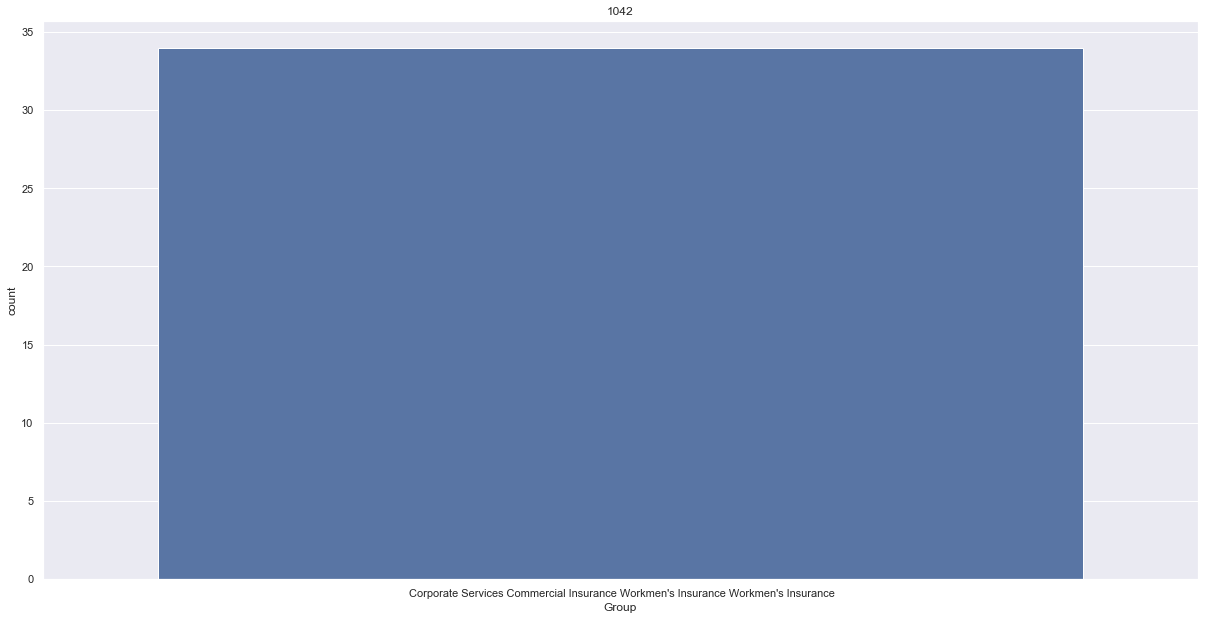

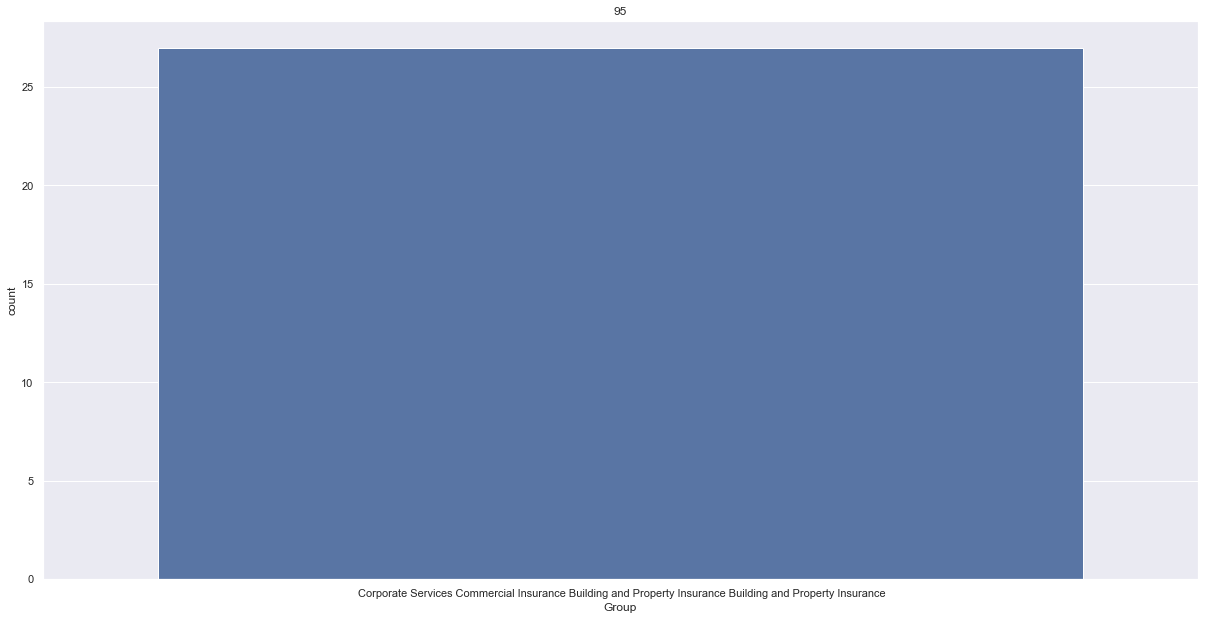

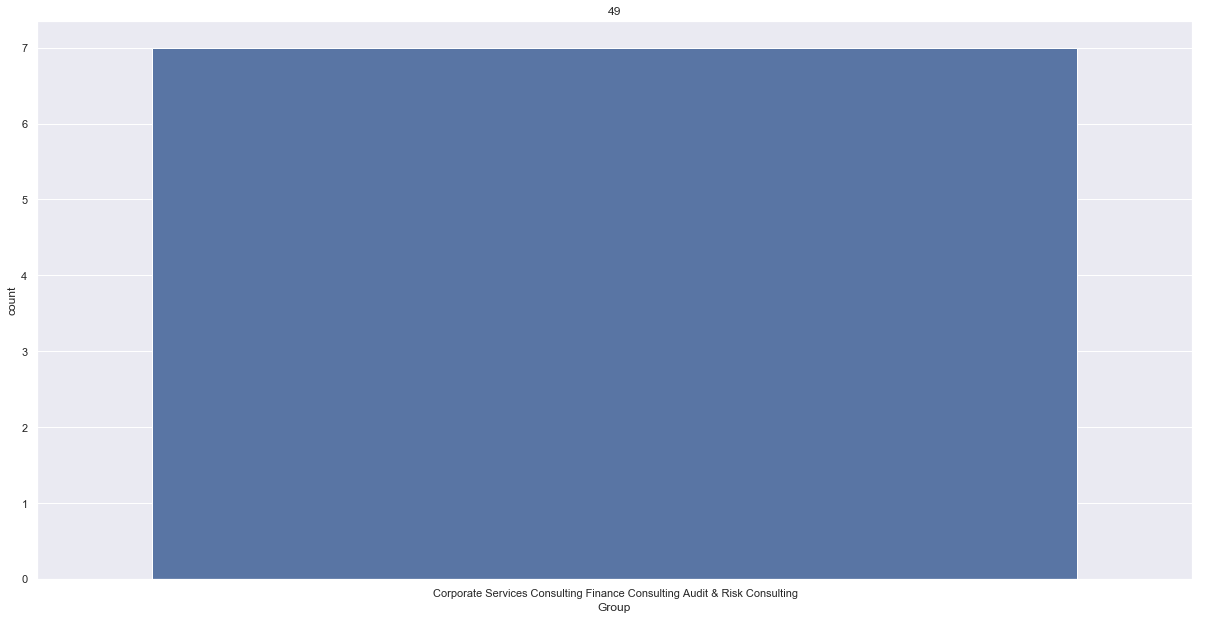

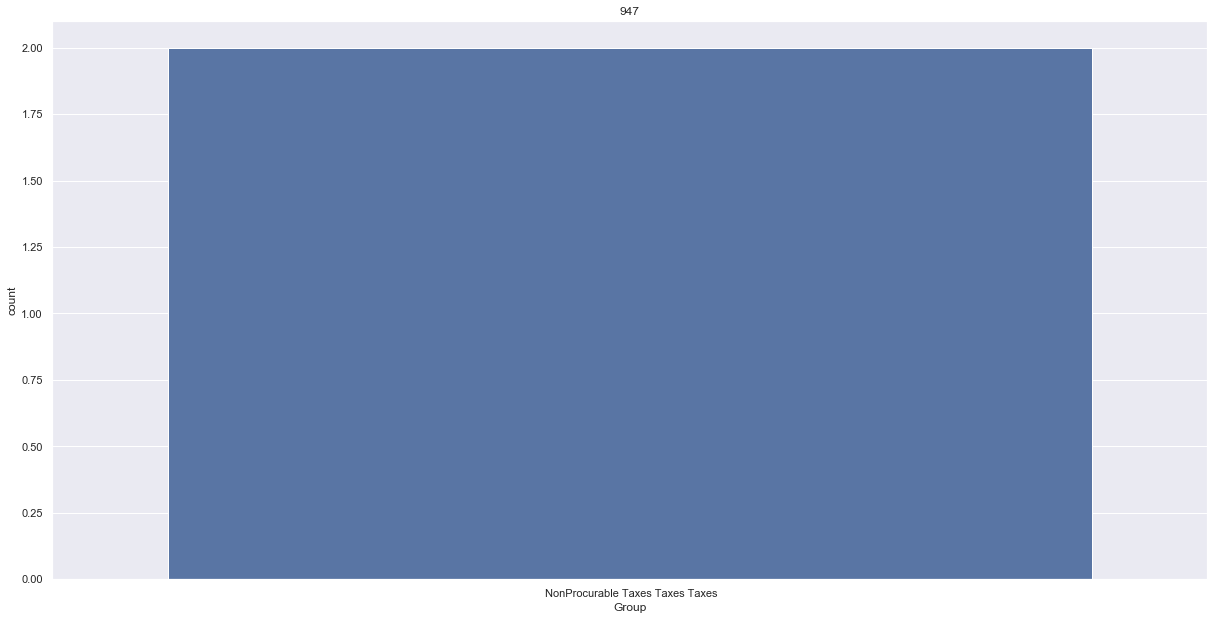

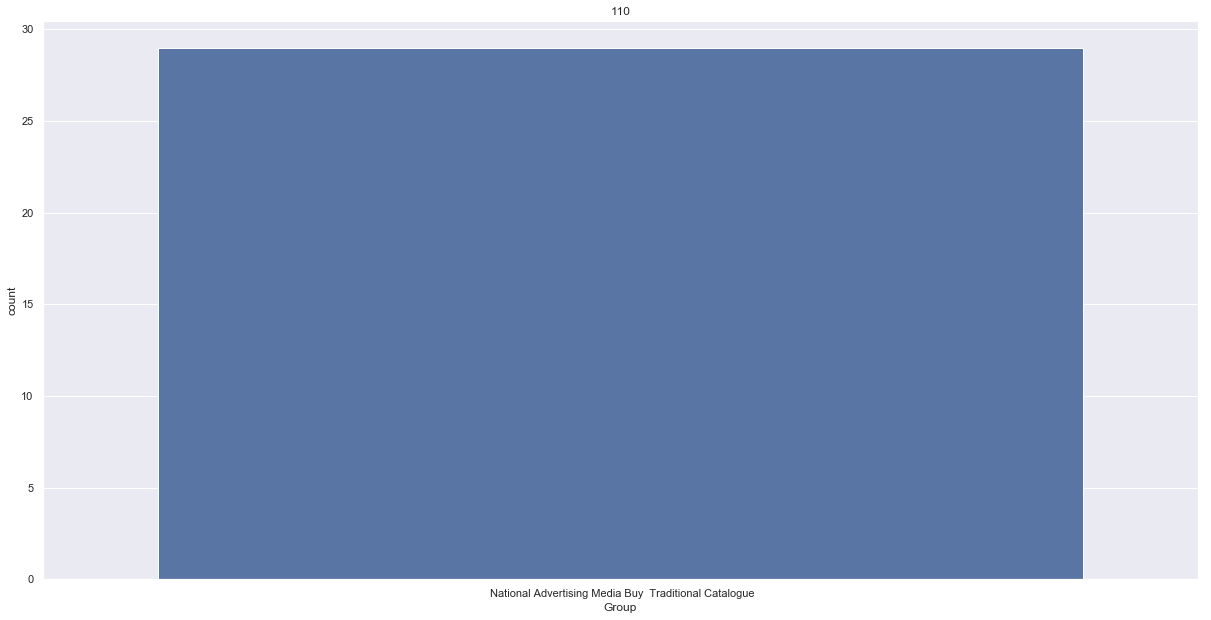

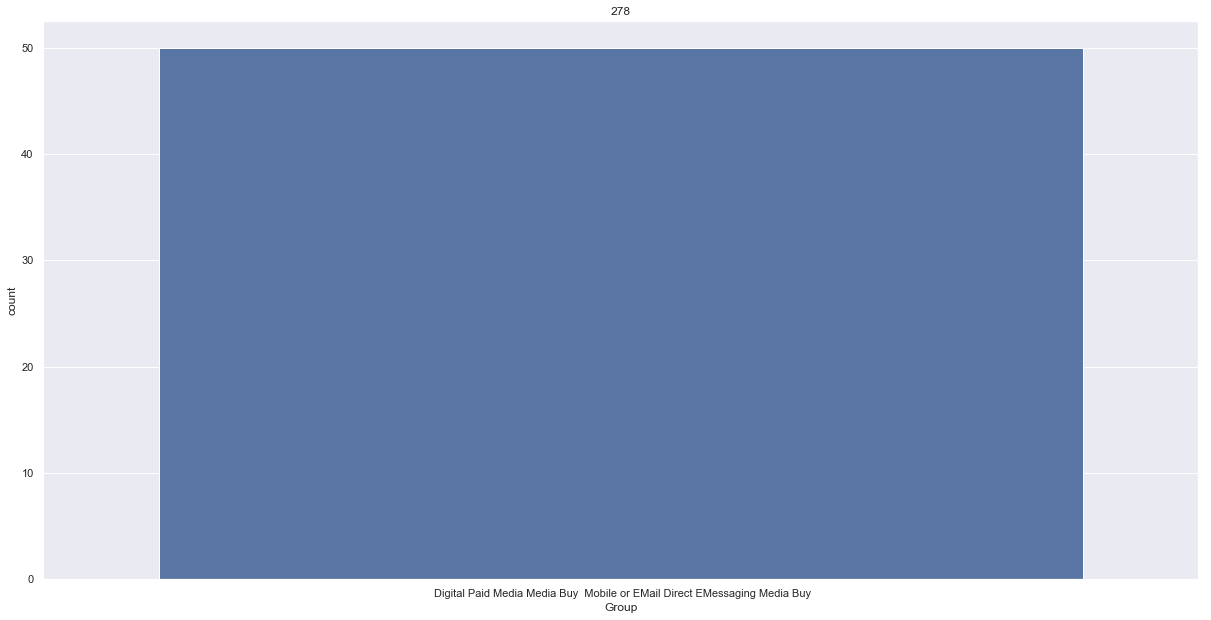

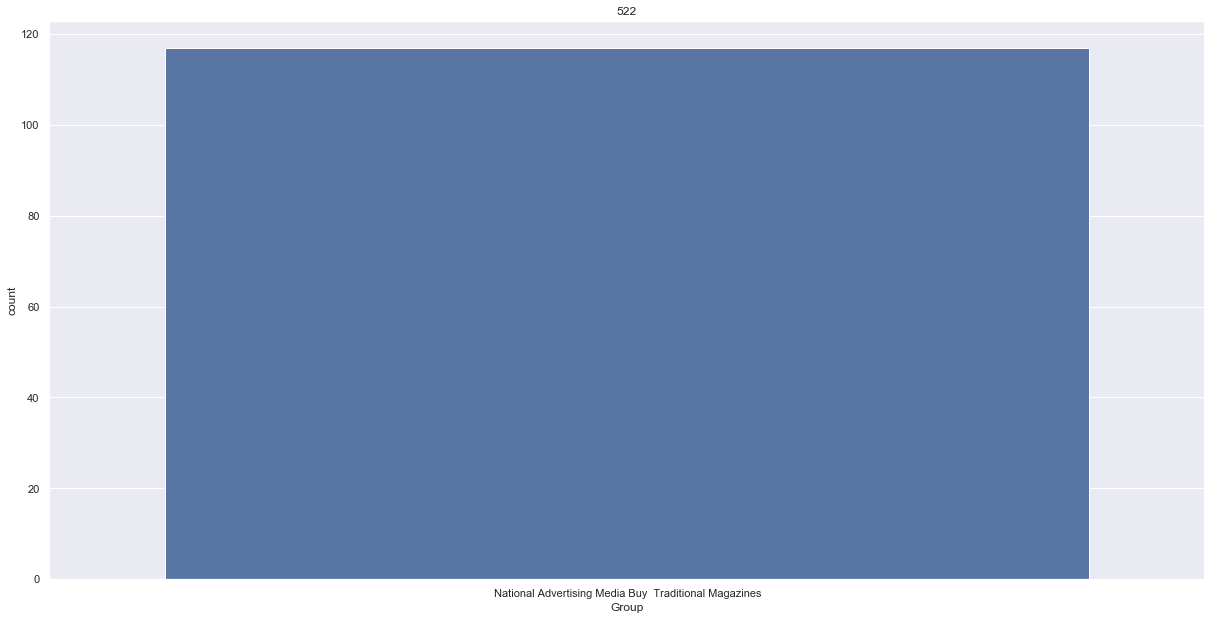

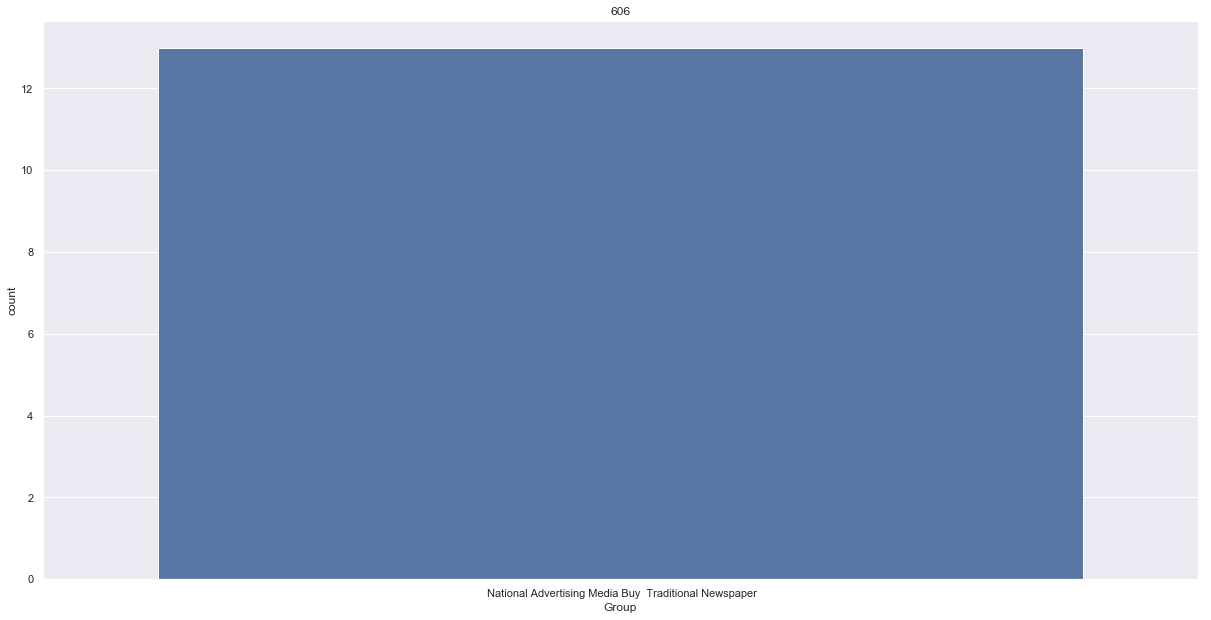

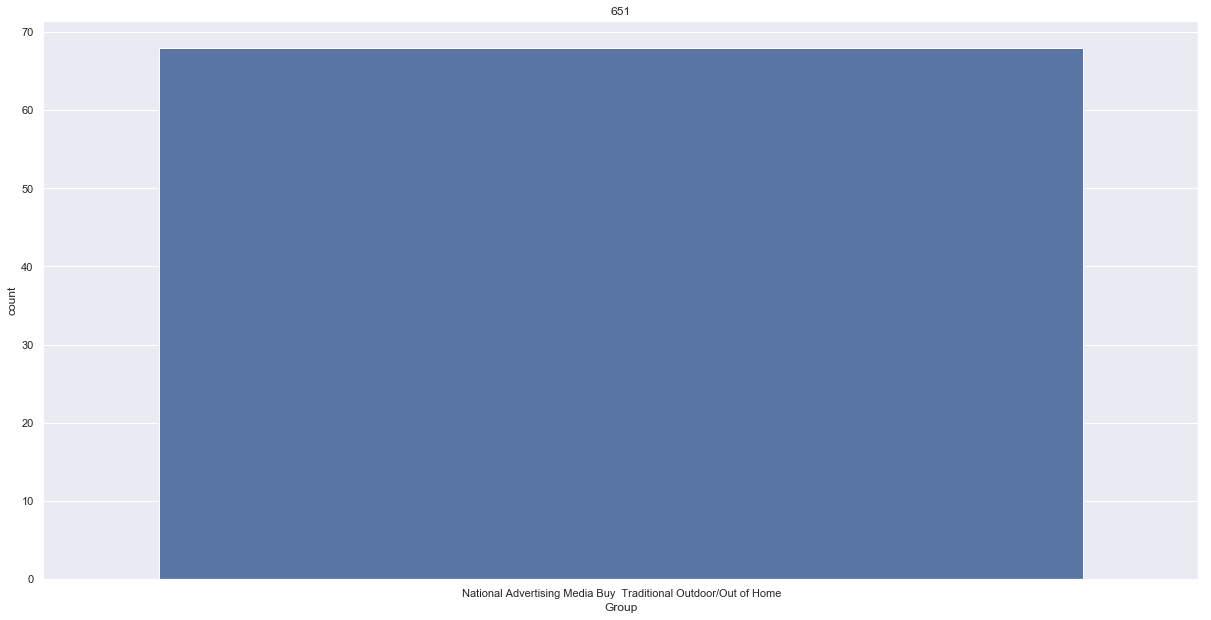

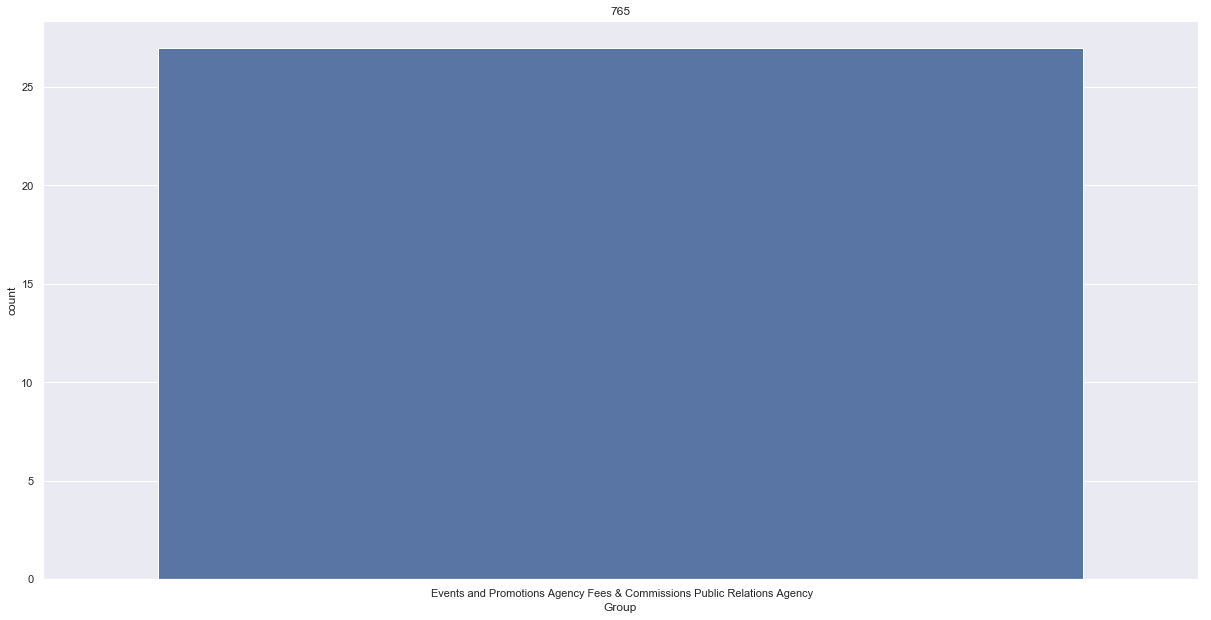

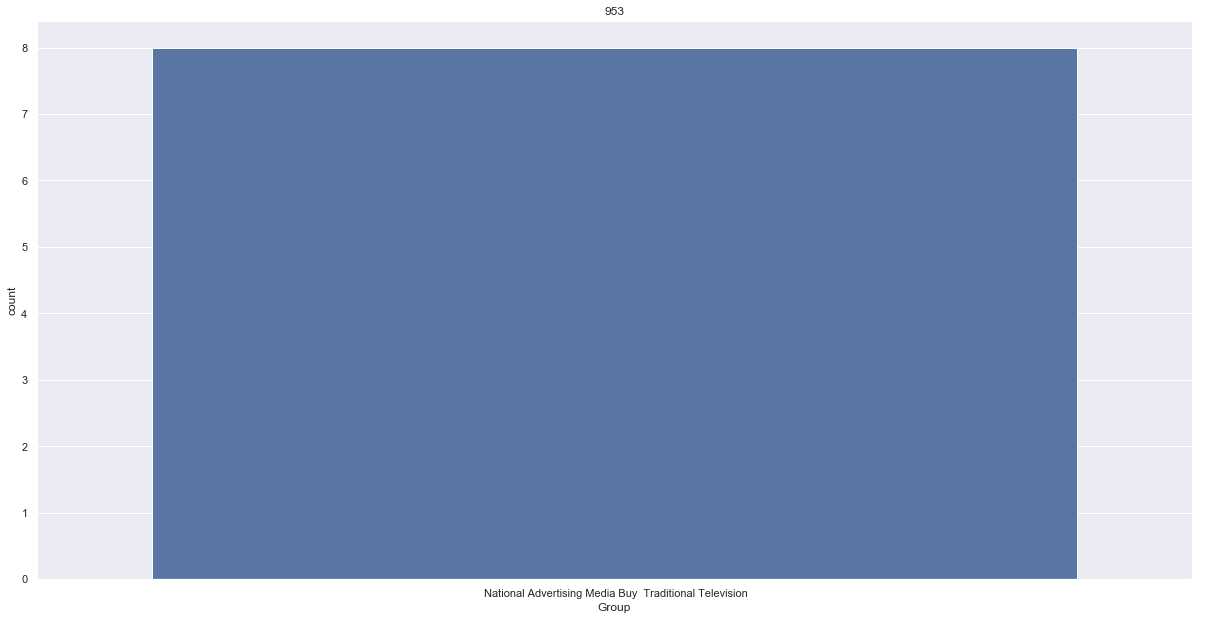

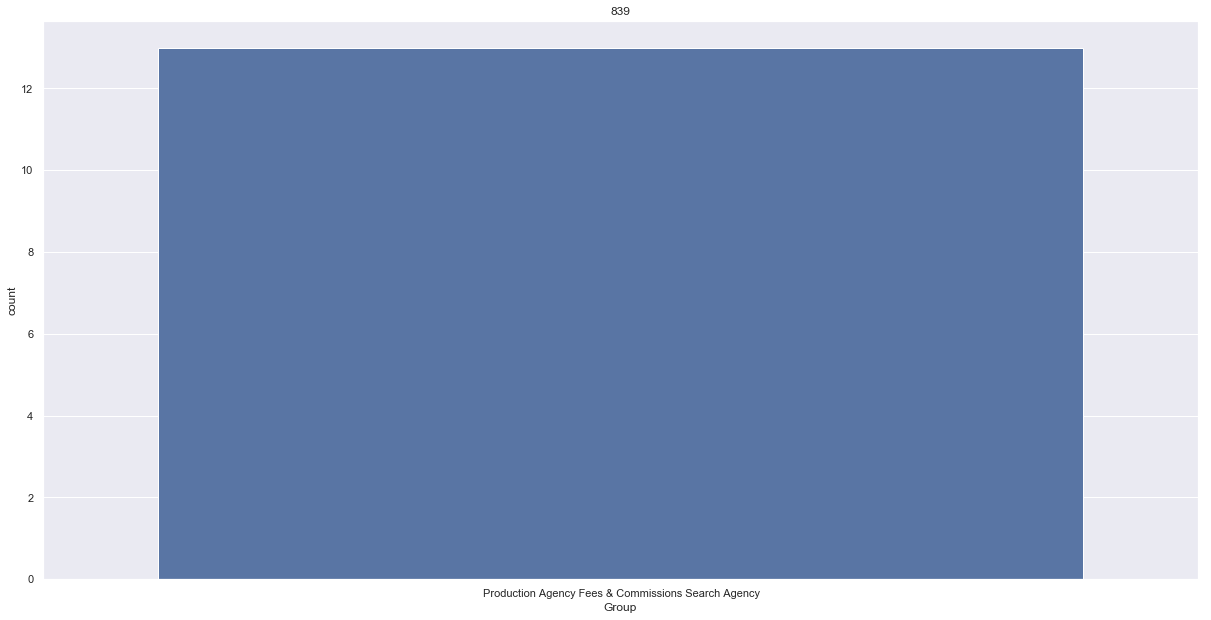

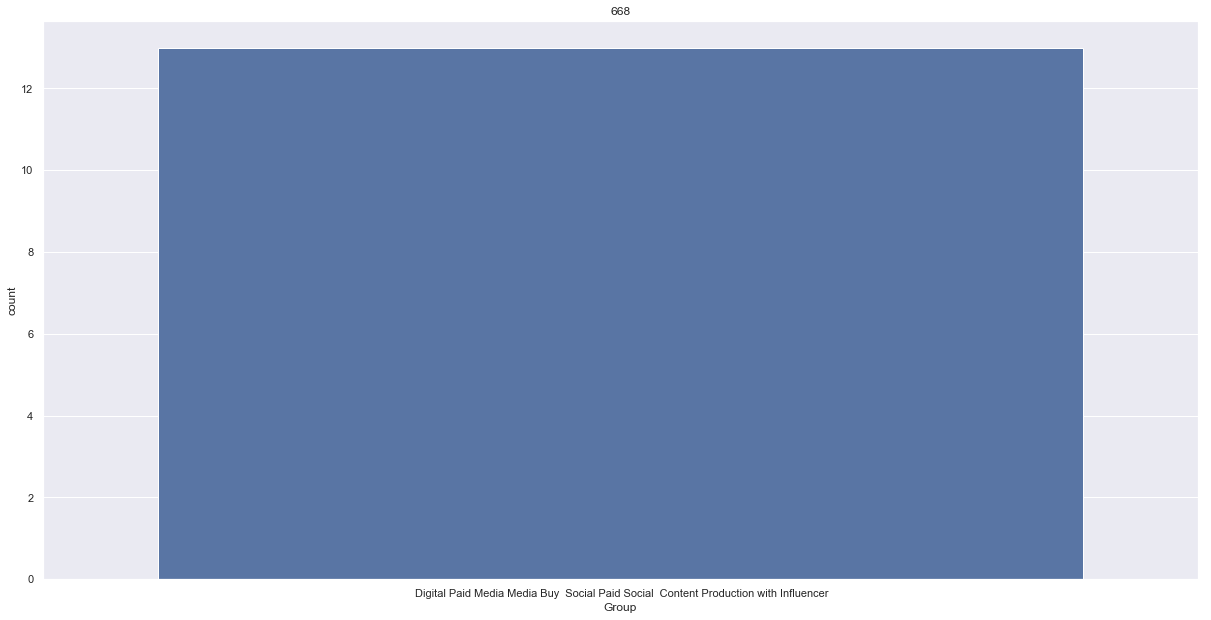

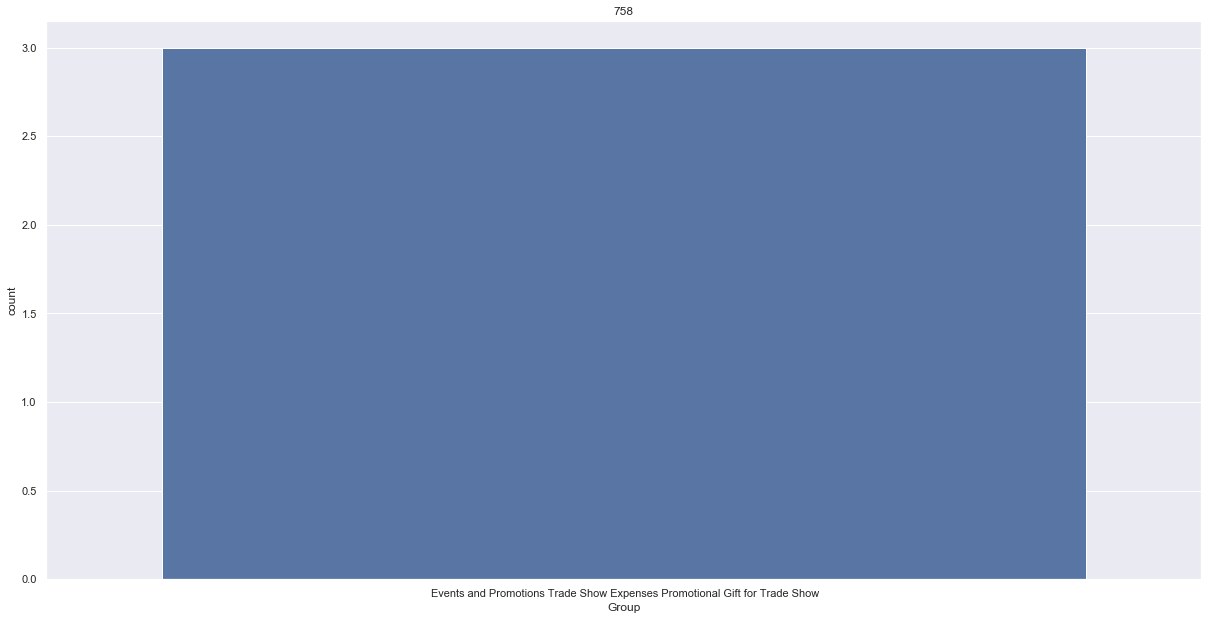

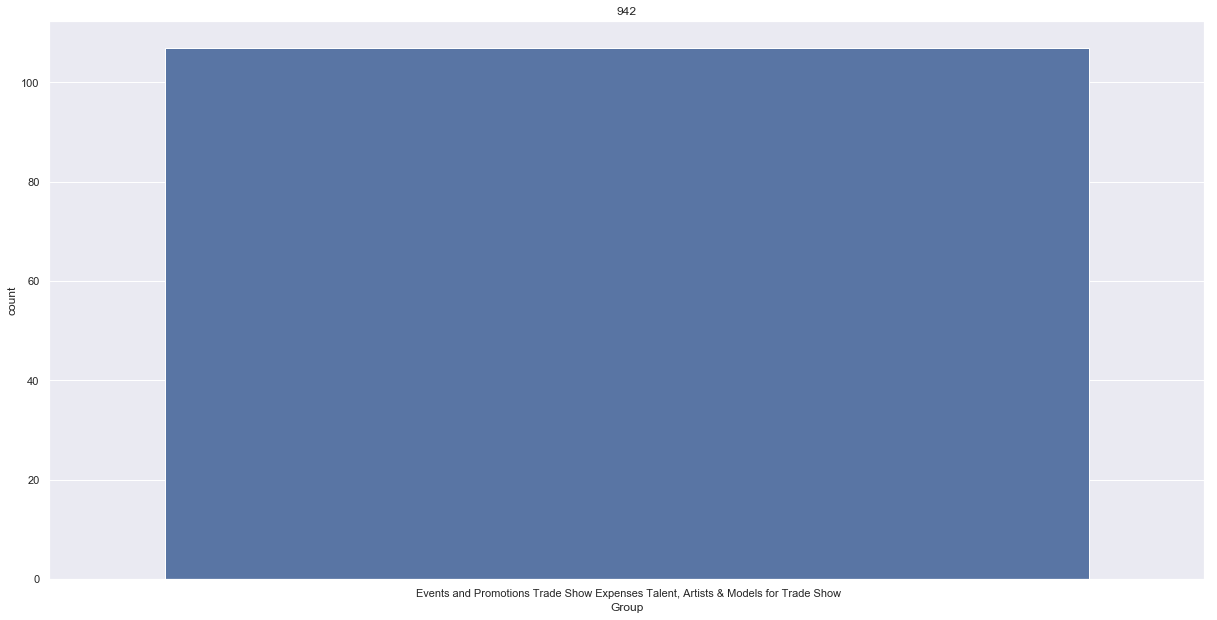

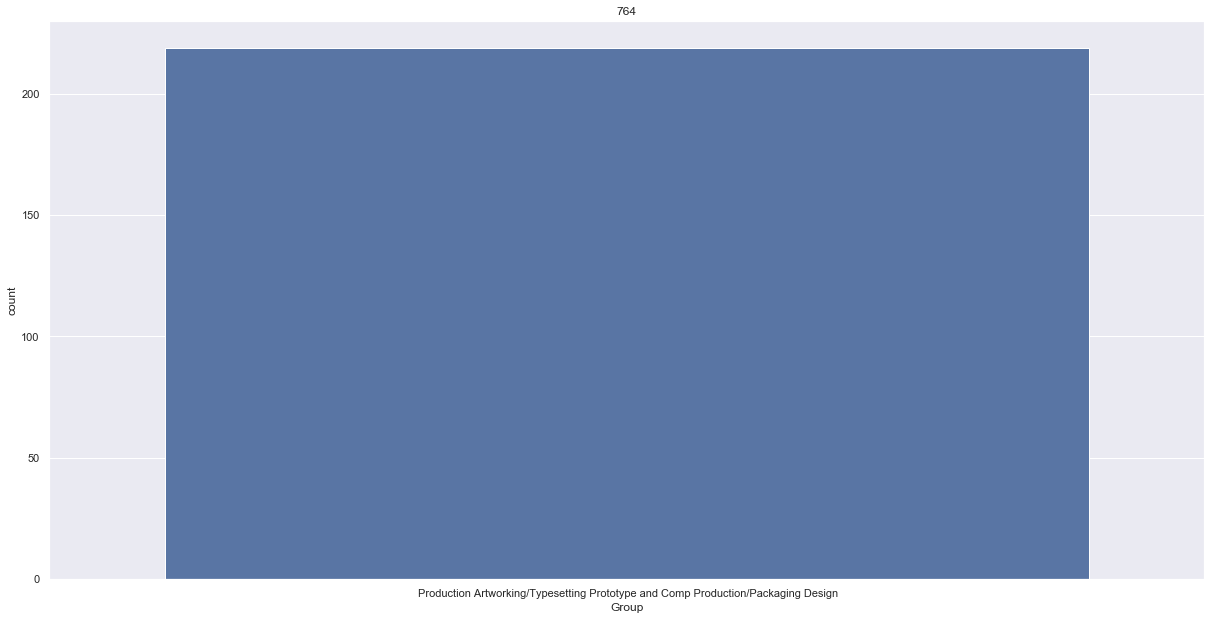

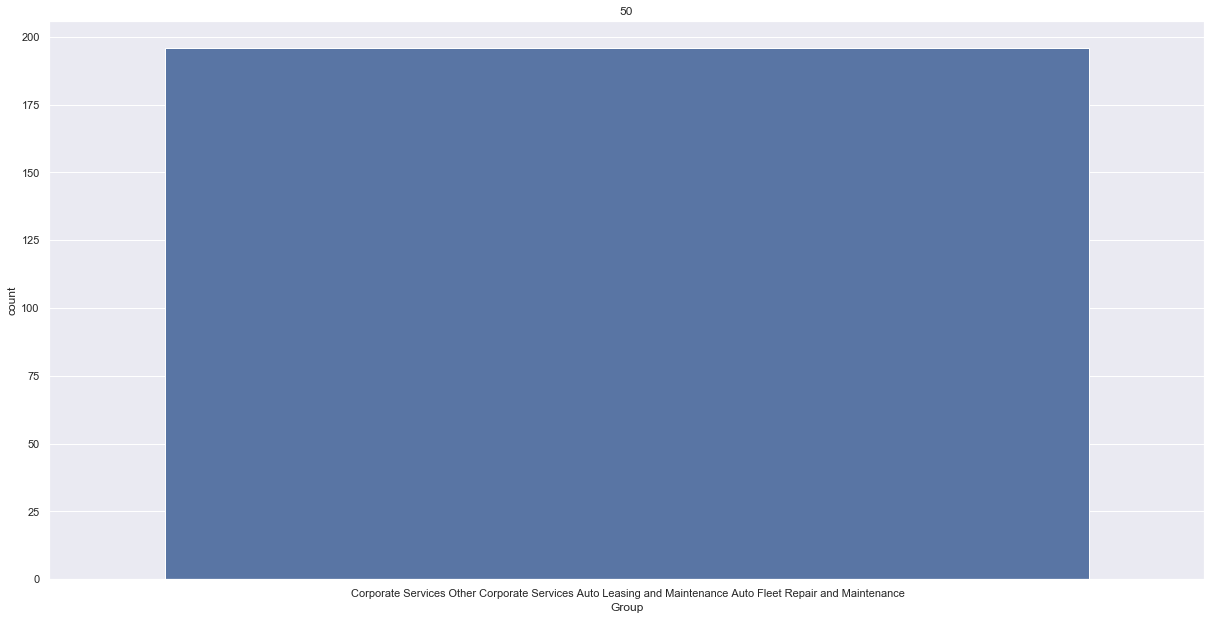

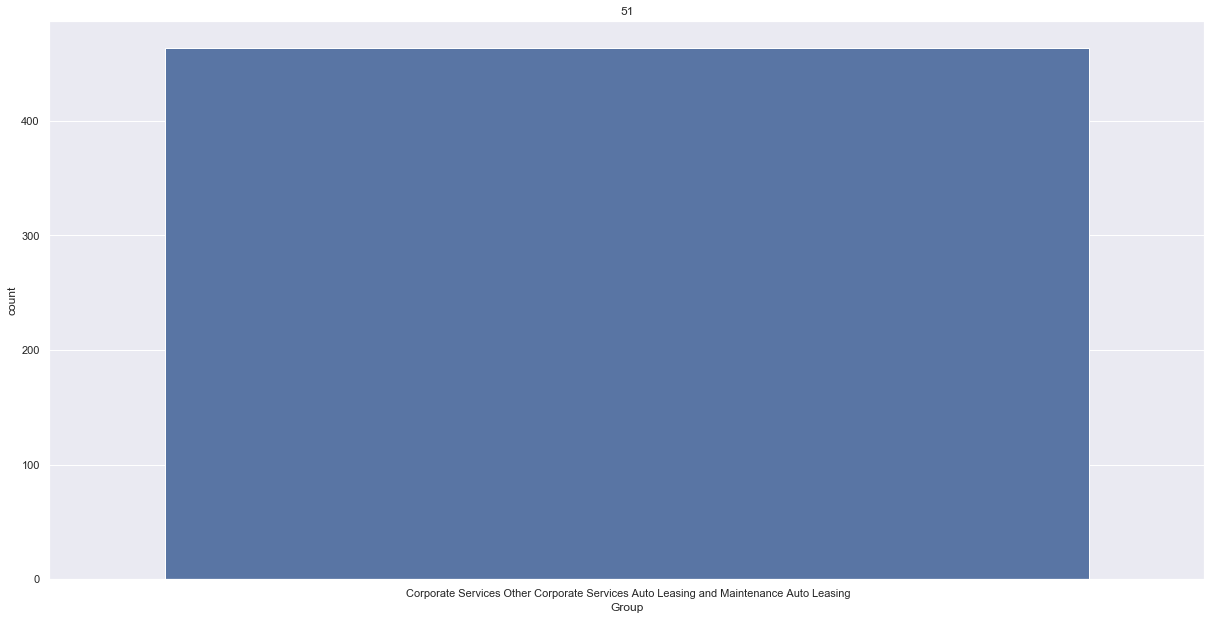

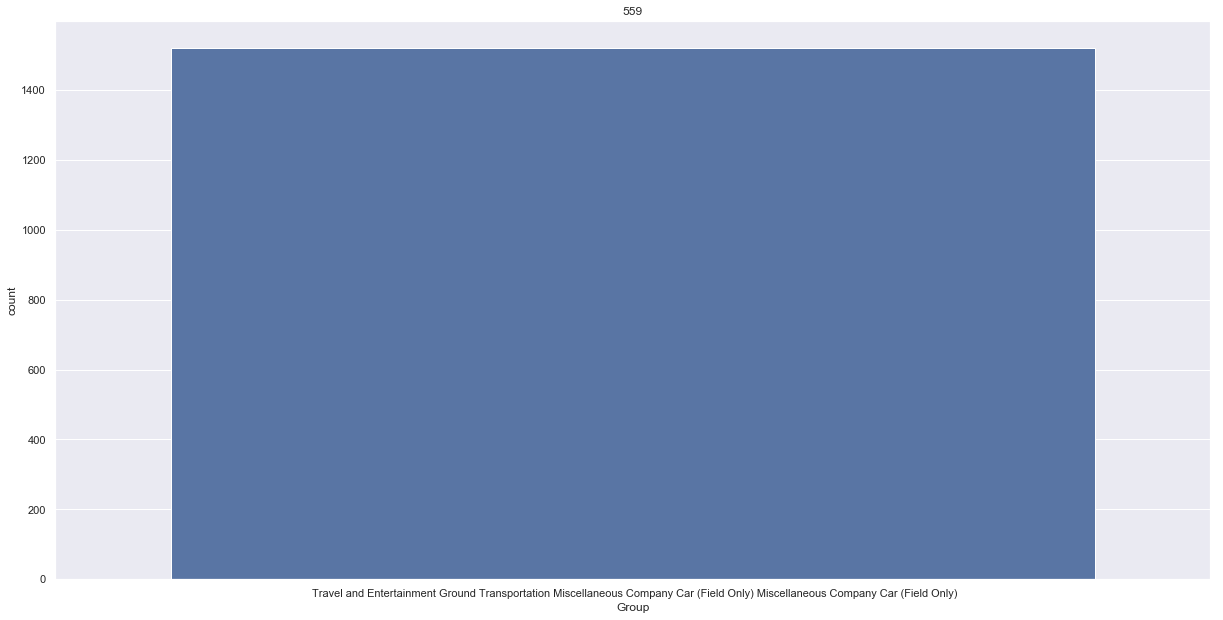

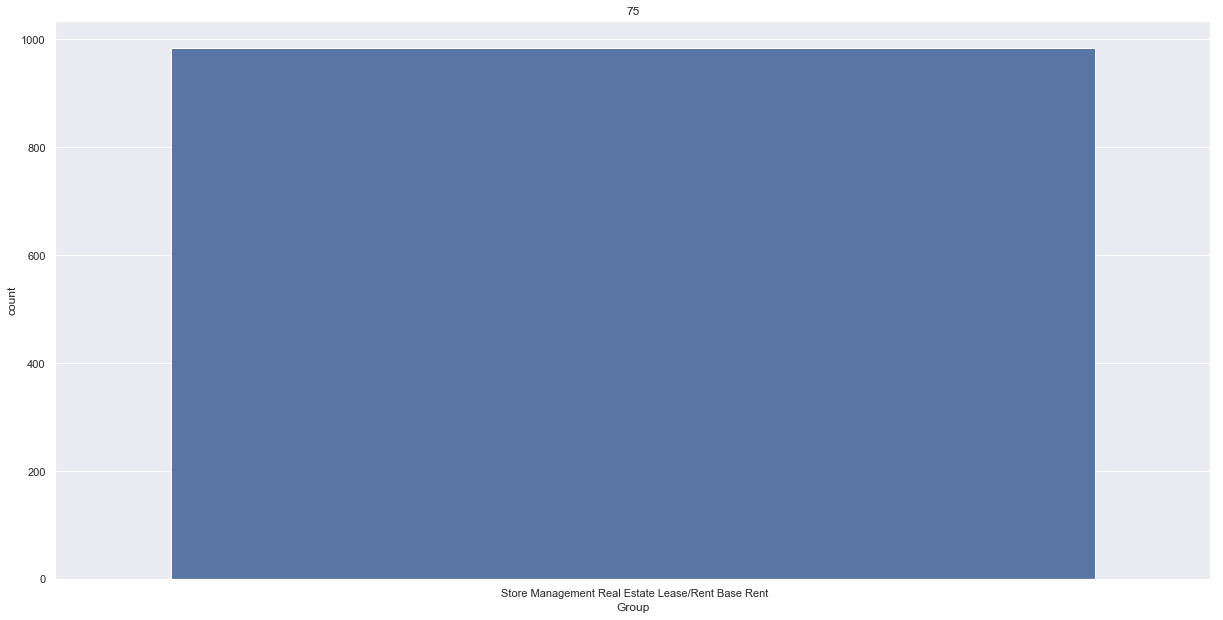

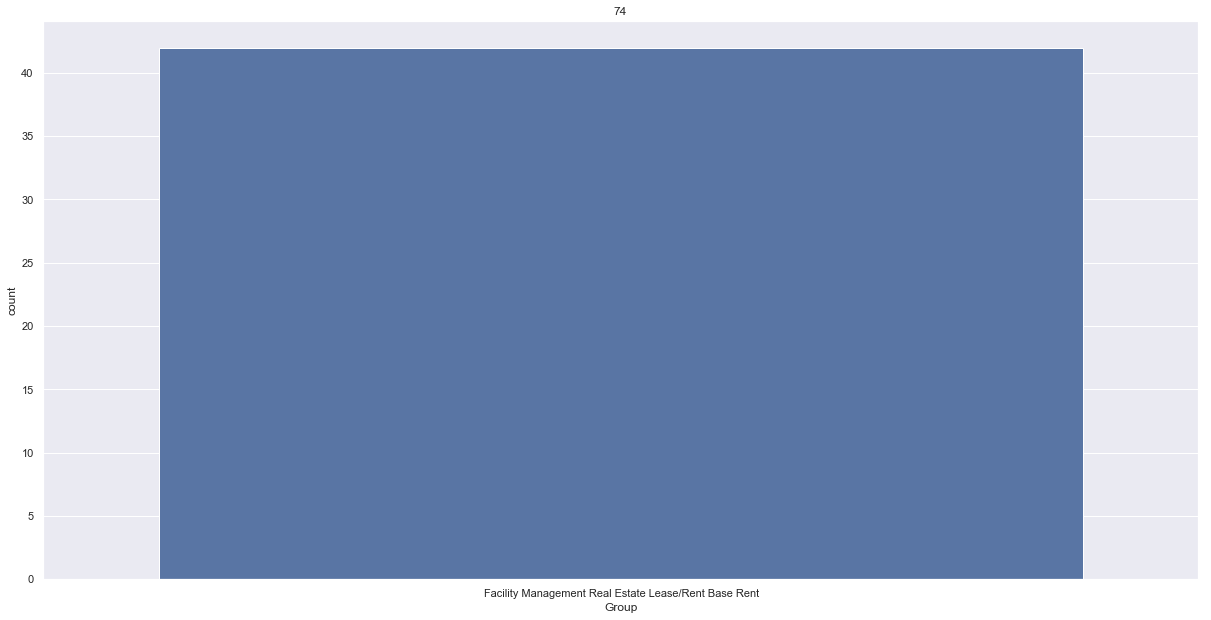

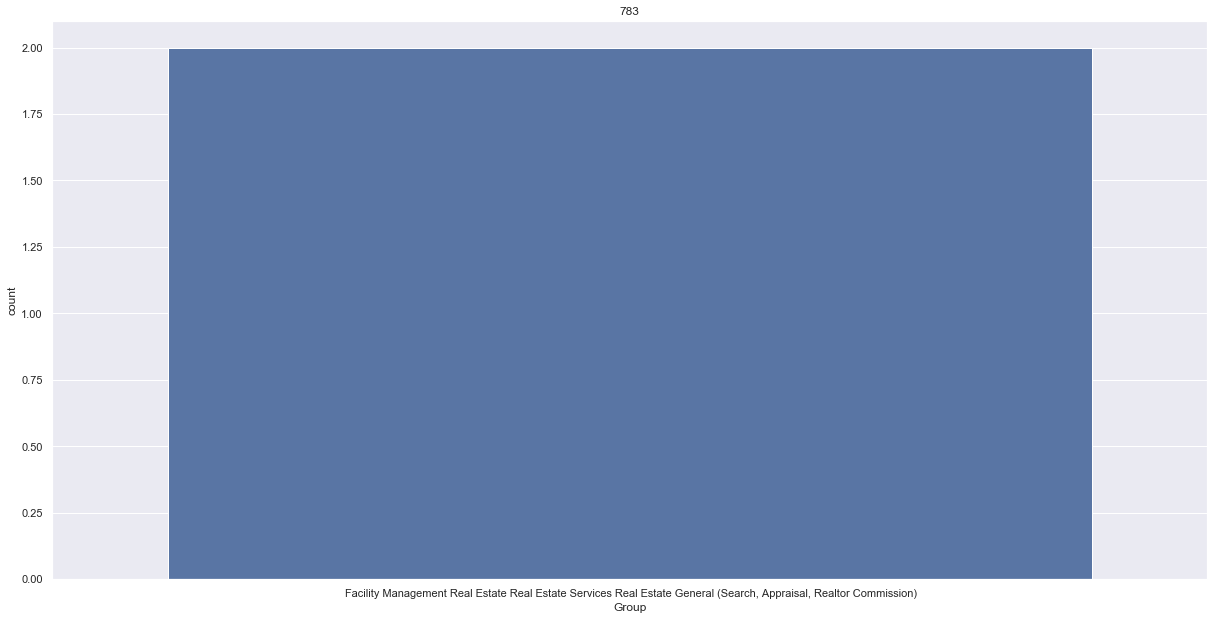

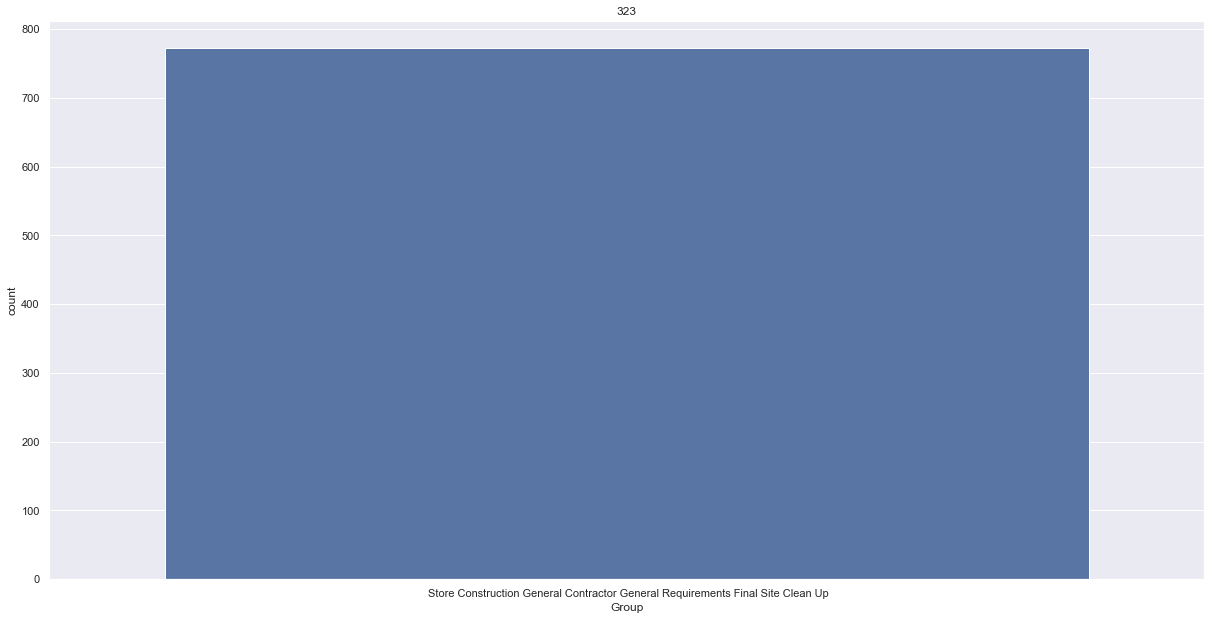

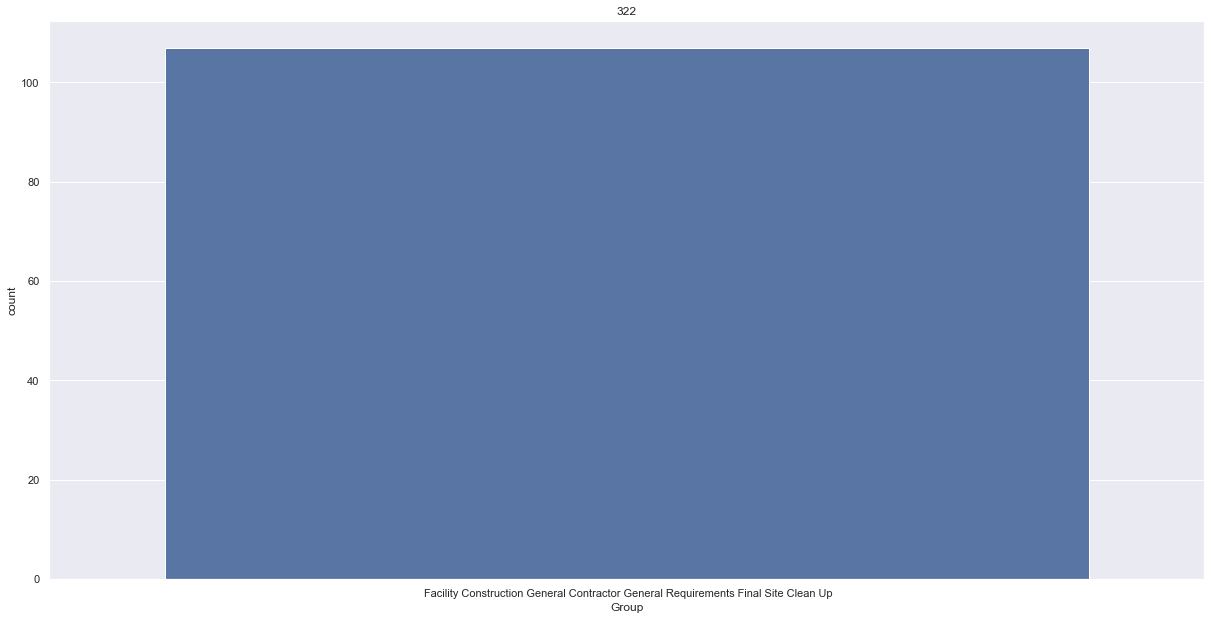

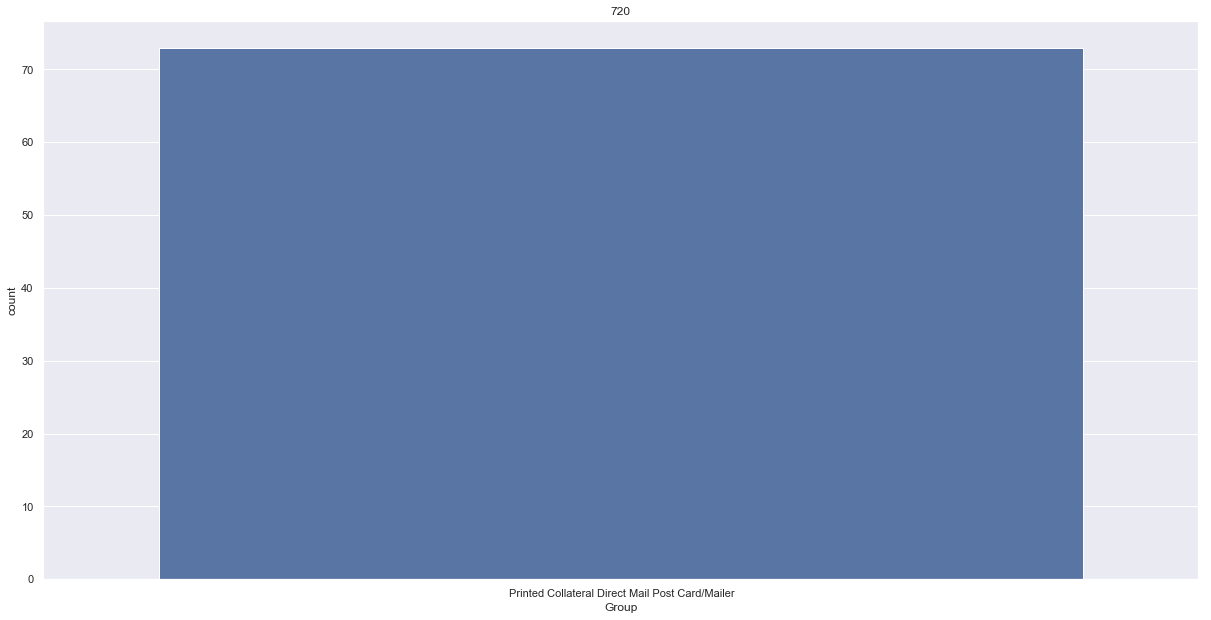

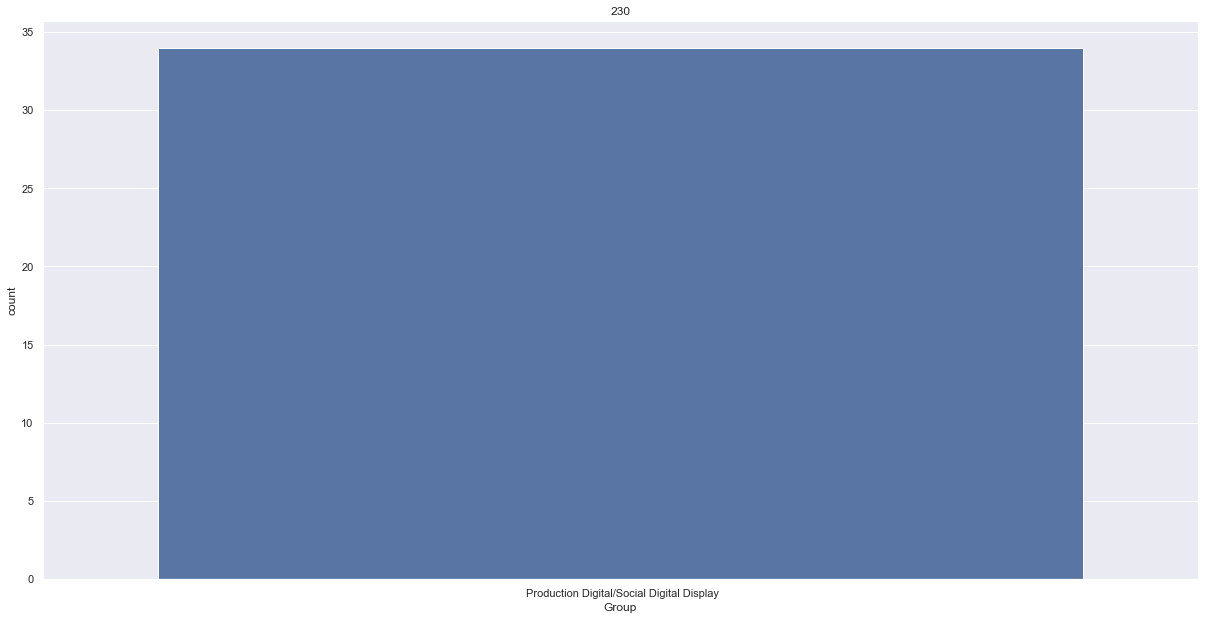

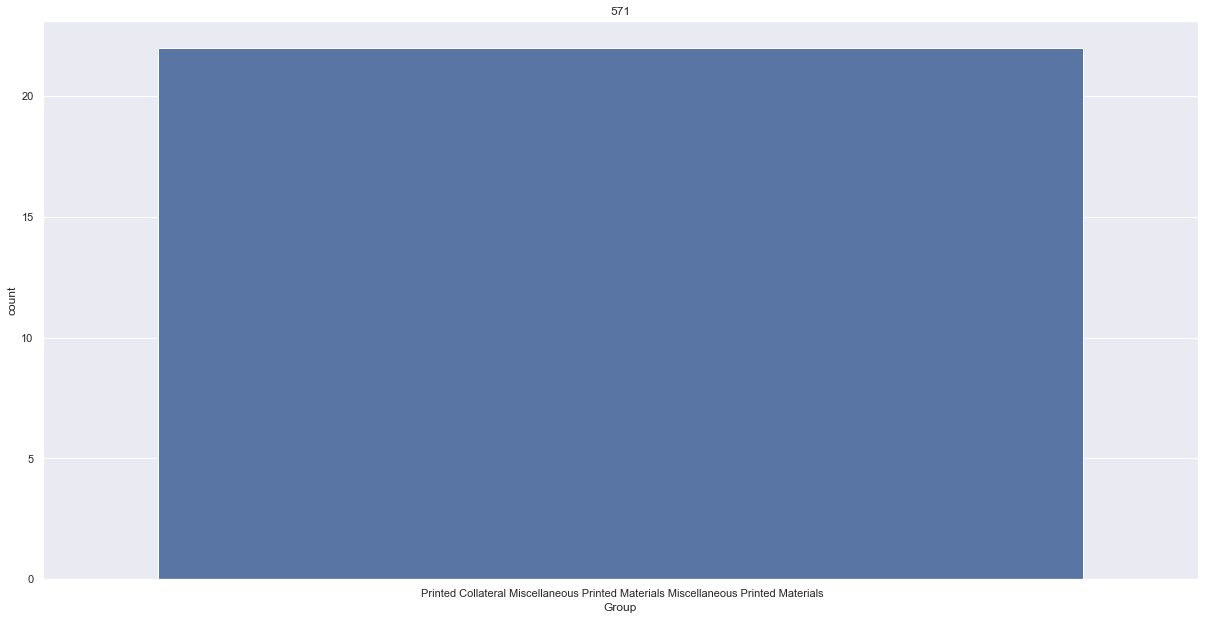

In [99]:
for i in train_modified['Product_Category_filtered'].unique():
    #print(i)
    plt.figure()
    grtempdf  = train_modified[train_modified["Product_Category_filtered"]== i]
    #sns.set(rc={'figure.figsize':(20.7,10.27)})
    sns.countplot(x = "Group", data=grtempdf).set_title(i)
    

In [21]:
train_modified['Group'].nunique(), train_modified['Product_Category'].nunique()

(38, 38)

> As can be seen No 2 group belongs to 1 product category so we can say there is 1 to 1 mapping between group and product_category, even though thales'U suggested that there is 0.75 correlation coefficient between group and product category. We can use this info for prediction 

In [22]:
df_predict = df [["Group", "Product_Category"]]

In [26]:
l=['Group']
df1=pd.get_dummies(df_predict, columns=l)

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8011 entries, 0 to 2291
Data columns (total 39 columns):
Product_Category                                                                                                                       5719 non-null object
Group_ Corporate Services Commercial Insurance Building and Property Insurance Building and Property Insurance                         8011 non-null uint8
Group_ Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance                                                 8011 non-null uint8
Group_ Corporate Services Consulting Finance Consulting Audit & Risk Consulting                                                        8011 non-null uint8
Group_ Corporate Services Human Resources Benefits Life and Health and Accident Insurance                                              8011 non-null uint8
Group_ Corporate Services Human Resources Benefits Retirement and Pension Funds                                      

In [28]:
li = []
for i in df1.columns:
    li.append(i)

    
print(li)

['Product_Category', 'Group_ Corporate Services Commercial Insurance Building and Property Insurance Building and Property Insurance', "Group_ Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance", 'Group_ Corporate Services Consulting Finance Consulting Audit & Risk Consulting', 'Group_ Corporate Services Human Resources Benefits Life and Health and Accident Insurance', 'Group_ Corporate Services Human Resources Benefits Retirement and Pension Funds', 'Group_ Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor', 'Group_ Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Fleet Repair and Maintenance', 'Group_ Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Leasing', 'Group_ Digital Paid Media Media Buy  Mobile or EMail Direct EMessaging Media Buy', 'Group_ Digital Paid Media Media Buy  Social Paid Social  Content Production with Influencer', 'Group_ Events and Prom

In [37]:
train_prediction = df1[:len(train)]
test_prediction = df1[len(train):]

In [38]:
test_prediction.head()

Product_Category  \
0              NaN   
1              NaN   
2              NaN   
3              NaN   
4              NaN   

   Group_ Corporate Services Commercial Insurance Building and Property Insurance Building and Property Insurance  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

   Group_ Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance  \
0                                                  0                                        
1                                                  0                                        
2                                                  0                                        
3                                                  0                                        
4                                                  0                                        

   Group_ Corporate Services Consulting Finance Consulting Audit & Risk Consulting  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   Group_ Corporate Services Human Resources Benefits Life and Health and Accident Insurance  \
0                                                  0                                           
1                                                  0                                           
2                                                  0                                           
3                                                  0                                           
4                                                  0                                           

   Group_ Corporate Services Human Resources Benefits Retirement and Pension Funds  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   Group_ Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor  \
0                                                  0                                                   
1                                                  0                                                   
2                                                  0                                                   
3                                                  0                                                   
4                                                  0                                                   

   Group_ Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Fleet Repair and Maintenance  \
0                                                  0                                                                   
1                                                  0                                                                   
2          

In [20]:
Prod_List = list(train_modified['Product_Category'].unique())

In [21]:
#print(train_modified[['VC_Filtered','Comp_Name']])
dt = {}
train_modified[['VC_Filtered','Comp_Name']].count()
for k,i in enumerate(train_modified['Comp_Name']):
    i = i.replace(".","")
    if i not in dt.keys():
        dt[i]=[train_modified['VC_Filtered'][k],]
    else:
        tl = dt[i]
        temp=train_modified['VC_Filtered'][k]
        #print(tl)
        #print("temp -->",temp)
        if temp in tl:
            continue
        else:
            dt[i].append(temp)

In [22]:
for i in dt.keys():
    if len(dt[i]) > 1:
        print(i,len(dt[i]))

> As can be seen 1 vendor code is mapped with one Company name hence they are correlated among themselves so we can remove one of the columns from prediction as that will not add value in prediction

In [44]:
Xtraincols=list(df1.columns)
Xtraincols.remove('Product_Category')
#print(Xtraincols)

In [51]:
x_train = train_prediction[Xtraincols]
y_train = train_prediction['Product_Category']


In [60]:
#x_train.isna().count()

In [57]:
dt = tree.DecisionTreeClassifier(random_state  = 1)
#Add parameters for tuning
#dt_grid = {'max_depth':[10, 11, 12], 'min_samples_split':[2,3,6,7,8], 'criterion':['gini','entropy']}
dt_grid = {'max_depth':list(range(5,20)), 'min_samples_split':list(range(2,5)), 'criterion':['gini','entropy']}

param_grid = model_selection.GridSearchCV(dt, dt_grid, cv=10) #Evolution of tee
param_grid.fit(x_train, y_train) #Building the tree
#param_grid.grid_scores
print(param_grid.best_score_) #Best score
print(param_grid.best_params_)
#print(param_grid.score(x_train, y_train))

C:\Users\Jyoti\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.9534883720930233
{'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 2}


C:\Users\Jyoti\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [61]:
X_test = test_prediction[Xtraincols]

In [62]:
X_test.head()

Group_ Corporate Services Commercial Insurance Building and Property Insurance Building and Property Insurance  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

   Group_ Corporate Services Commercial Insurance Workmen's Insurance Workmen's Insurance  \
0                                                  0                                        
1                                                  0                                        
2                                                  0                                        
3                                                  0                                        
4                                                  0                                        

   Group_ Corporate Services Consulting Finance Consulting Audit & Risk Consulting  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   Group_ Corporate Services Human Resources Benefits Life and Health and Accident Insurance  \
0                                                  0                                           
1                                                  0                                           
2                                                  0                                           
3                                                  0                                           
4                                                  0                                           

   Group_ Corporate Services Human Resources Benefits Retirement and Pension Funds  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   Group_ Corporate Services Human Resources Contingent Labor/Temp Labor Contingent Labor/Temp Labor  \
0                                                  0                                                   
1                                                  0                                                   
2                                                  0                                                   
3                                                  0                                                   
4                                                  0                                                   

   Group_ Corporate Services Other Corporate Services Auto Leasing and Maintenance Auto Fleet Repair and Maintenance  \
0                                                  0                                                                   
1                                                  0                                                                   
2                                                  0                                                                   
3                        

In [64]:
param_grid.predict(X_test)

array(['CLASS-1042', 'CLASS-1042', 'CLASS-1042', ..., 'CLASS-1042',
       'CLASS-1042', 'CLASS-1042'], dtype=object)

In [67]:
test_modified.to_csv("Submission.csv",columns=['inv_id','Product_Category'],index=False)